# Data Diri
Nama : David William Tanto, Oei

# Import Module

In [1]:
import numpy as np 
import pandas as pd 
import random
import tensorflow as tf
import os,cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Input, Dropout

# Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Data

In [3]:
paths = ['/content/drive/MyDrive/Indosat/kursus4/Classification/seg_train', 
         '/content/drive/MyDrive/Indosat/kursus4/Classification/seg_test']

labels = []
for folder in os.listdir(paths[0]):
    labels.append(folder)

print(labels)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [4]:
dicc_labels={i:labels[i] for i in range(0,len(labels))}
dicc_labels

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [30]:
n = []
s = 64
_images = []
_labels = []
for j in range(0,2):
  for i,folder in enumerate(labels):
      try:
          for image in os.listdir(paths[j] +'/'+folder):
              img = os.path.join(paths[j]+'/'+folder+'/'+image)
              img = cv2.imread(img)
              img = cv2.resize(img,(s,s))
              _images.append(img)
              _labels.append(i)
      except:
          print("gagal")
  n.append(len(_images))

_images = np.asarray(_images)
_labels = np.asarray(_labels).astype('int64')
print("Ukuran gambar -> ",_images.shape)
print("Jumlah data per label -> ",np.bincount(_labels))

Ukuran gambar ->  (3000, 64, 64, 3)
Jumlah data per label ->  [500 500 500 500 500 500]


# Standard Scaler

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
_images =_images.reshape((len(_images),-1))

scaler.fit(_images)
_images_scal = scaler.transform(_images)

# Modeling

## Splitting Data

In [33]:
from keras.utils import to_categorical

X_train = _images_scal[0:n[0]]
X_test = _images_scal[n[0]:n[1]]

y_train = _labels[0:n[0]]
y_test = _labels[n[0]:n[1]]


X_train = X_train.reshape(len(X_train),s,s,3)
X_test = X_test.reshape(len(X_test),s,s,3)

print("Gambar Training-> ",X_train.shape, "labels train-> ",y_train.shape)
print("Jumlah per kategori (Training) -> ", np.bincount(y_train))
print("Gambar Testing -> ",X_test.shape, "labels train-> ",y_test.shape)
print("Jumlah per kategori (Testing) -> ", np.bincount(y_test))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Gambar Training->  (2400, 64, 64, 3) labels train->  (2400,)
Jumlah per kategori (Training) ->  [400 400 400 400 400 400]
Gambar Testing ->  (600, 64, 64, 3) labels train->  (600,)
Jumlah per kategori (Testing) ->  [100 100 100 100 100 100]


## Build Model

In [34]:
model = keras.models.Sequential([
        keras.layers.Conv2D(5,kernel_size=(5,5),activation='relu',input_shape=(64,64,3)),
        keras.layers.AveragePooling2D (2,2),
        keras.layers.Conv2D(16,kernel_size=(5,5),activation='relu'),    
        keras.layers.MaxPool2D(2,2),
        keras.layers.Flatten() ,   
        keras.layers.Dense(512,activation='relu') ,            
        keras.layers.Dense(6,activation='softmax') ,    
        ])

## Compile Model

In [35]:
model.compile(optimizer="adam", 
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"]
)

## Model Summary

In [36]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 60, 60, 5)         380       
                                                                 
 average_pooling2d_2 (Averag  (None, 30, 30, 5)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_14 (Conv2D)          (None, 26, 26, 16)        2016      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 2704)              0         
                                                                 
 dense_7 (Dense)             (None, 512)              

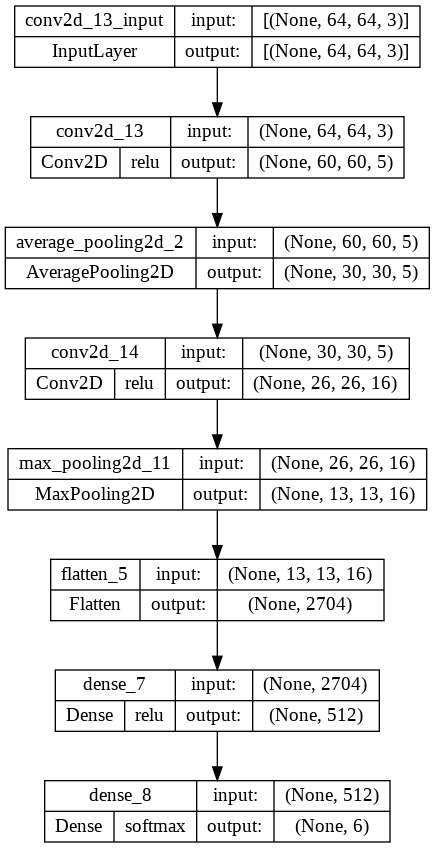

In [37]:
tf.keras.utils.plot_model(model, 
                          show_shapes = True, 
                          show_dtype = False, 
                          show_layer_names = True, 
                          expand_nested = True, 
                          show_layer_activations = True)

## Early Stopping

In [44]:
from keras.callbacks import EarlyStopping

In [47]:
es = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

## Fitting Model

In [51]:
history = model.fit(X_train, y_train, 
                    validation_split = 0.2,
                    epochs = 10,
                    batch_size = 256,
                    callbacks = es,
                    verbose = 1)

Epoch 1/10
8/8 [==============================] - 43s 917ms/step - loss: 0.0142 - accuracy: 0.9995 - val_loss: 0.0320 - val_accuracy: 0.9979
Epoch 2/10
8/8 [==============================] - 9s 1s/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.0994 - val_accuracy: 0.9729
Epoch 3/10
8/8 [==============================] - 12s 1s/step - loss: 0.0091 - accuracy: 0.9995 - val_loss: 0.1377 - val_accuracy: 0.9604
Epoch 4/10
8/8 [==============================] - 9s 1s/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.1585 - val_accuracy: 0.9521
Epoch 4: early stopping


## Visualisasi 

### Training Accuracy

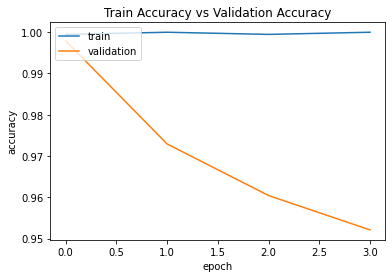

In [54]:
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['val_accuracy'], label = "val_accuracy")
plt.title('Train Accuracy vs Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Training Model Loss

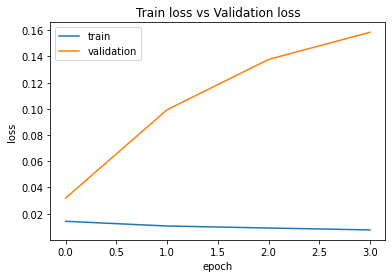

In [55]:
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.title('Train loss vs Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [56]:
print(dicc_labels)

pred = model.predict(X_test)

print(classification_report(
    np.argmax(y_test,axis=1),
    np.argmax(pred, axis=1)
))

{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
19/19 [==============================] - 1s 60ms/step
              precision    recall  f1-score   support

           0       0.65      0.60      0.63       100
           1       0.73      0.88      0.80       100
           2       0.56      0.69      0.62       100
           3       0.65      0.56      0.60       100
           4       0.55      0.54      0.55       100
           5       0.72      0.57      0.64       100

    accuracy                           0.64       600
   macro avg       0.64      0.64      0.64       600
weighted avg       0.64      0.64      0.64       600



# Save Model

In [57]:
save_path = 'mymodel/'
tf.saved_model.save(model, save_path)

In [58]:
converter = tf.lite.TFLiteConverter.from_saved_model("/content/mymodel")
tflite_model = converter.convert()
 
with tf.io.gfile.GFile('model_name.tflite', 'wb') as f:
    f.write(tflite_model)